# On the advantage of assuming constant mass flow rates in discretized dynamic material flow models. 

by Oliver Cencic, Rudolf Frühwirth

2024-03-04

This code is based on code published by Dirk Lauinger (version v1.0.0, from Oct 20, 2020, https://doi.org/10.5281/zenodo.4110806) used to generate Figures 4 and 5 for the paper "A General Theory for Stock Dynamics of Populations and Built and Natural Environments", written by Dirk Lauinger, Romain G. Billy, Daniel B. Müller, Felipe Vásquez.

## General model definitions

In [72]:
# -- import relevant libraries
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import weibull_min
from scipy.stats import triang
from scipy.stats import uniform
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

In [74]:
# -- define problem parameters

T = 100     # length of planning horizon
N = 100      # number of periods 
dt = T/N    # duration of each period (time)

# time steps
t = np.arange(0,T+dt,dt) # gives an array 0 to T with step dt
# Note: with np.arange(start, stop), values are generated within the half-open interval [start, stop).
# Thus "stop" is not included!

In [76]:
# -- define life time distribution

dist = 3

if dist == 1:   # truncated normal
    mu = 10     # mean lifetime (time)
    sig = 3     # standard deviation (time)
    a = (0 - mu) / sig
    def pdf(x):
        return truncnorm.pdf(x,a,np.inf,mu,sig)
    def cdf(x):
        return truncnorm.cdf(x,a,np.inf,mu,sig)
    mean = truncnorm.mean(a,np.inf,mu,sig)
    
elif dist == 2:     # triangular
    a = 0           # left point of triangular distribution
    c = 2           # peak of triangular distribution
    b = 4           # right point of triangular distribution
    c = (c-a)/(b-a) # normalized peak of triangular distribution (between 0 and 1)
    offset = a      # offset of triangular distribution 
    scale = b-a     # length of triangular distribution
    def pdf(x):
        return triang.pdf(x,c,offset,scale)
    def cdf(x):
        return triang.cdf(x,c,offset,scale)  
    mean = triang.mean(c,offset,scale)
    
elif dist == 3:     # weibull
    k = 2           # k of weibull
    lam = 30         # lambda of weibull distribution
    off = 0         # offset of weibull distribution
    def pdf(x):
        return weibull_min.pdf(x,k,off,lam)
    def cdf(x):
        return weibull_min.cdf(x,k,off,lam)
    mean = weibull_min.mean(k,off,lam)
    
else:               # uniform
    off = 0         # offset of uniform distribution
    scale = 4      # lenght of uniform distribution
    def pdf(x):
        return uniform.pdf(x,off,scale)
    def cdf(x):
        return uniform.cdf(x,off,scale)
    mean = uniform.mean(off,scale)

# convolution of uniform input with selected LTD
def con_pdf(x,dx):
    return (cdf(x)-cdf(x-np.minimum(x,dx)))/dx

# numerical integration of con_pdf in the interval [x,x+dx]
def con_p(x,dx):
    n = 100
    di = dx/n
    P = 0
    for i in np.arange(x+di/2,x+dx,di):  # numerical central integration
        P = P + con_pdf(i,dx)*di
    return P

In [78]:
# build lifetime matrices

# Paper (Dirk Lauinger)
# uses pdf at start of period and 'normalization' to LTD of period
Lo = np.zeros((N,N))
for n in range(N):
    Lo = Lo + np.diag(np.ones(N - n)*pdf(n*dt), k = -n)
Lo = Lo/Lo[:,0].sum()*cdf(N*dt) # normalization; "*cdf(N*dt)" is necessary if LTD is longer than T!  

# OC (Oliver Cencic)
# uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear at start of period. The input and LDT from period 1 are used to
# compute output of period 1.
Ls = np.zeros((N,N))
for n in range(N):
    Ls = Ls + np.diag(np.ones(N - n)*(cdf(t[n+1])-cdf(t[n])), k = -n)
# print(Ln)   

# SP (Stefan Pauliuk)
# also uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear at end of period. Thus, the input and the LTD from period 1
# are used to compute the outout of period 2! No output in period 1!
# Equivalent to shifting the LTD one period to the right (compared to OC).
Le = np.zeros((N,N))
for n in range(1,N):
    Le = Le + np.diag(np.ones(N - n)*(cdf(t[n])-cdf(t[n-1])), k = -n)
# print(Ln1) 
    
# OC, uniform input
# also uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear uniformly distributed over the period.
# The input and LDT from period 1 are then used to compute output of period 1. 
Lu = np.zeros((N,N))
for n in range(N):
    Lu = Lu + np.diag(np.ones(N - n)*con_p(t[n],dt), k = -n)
# print (Ln2)    

# computation of d
L_mean = mean
d = 1/L_mean

## Lifetime vs. death rate (stock driven model)

The figures created in this section compare the evolution of inflows and outflows under a time independent lifetime distribution and a constant death rate, equal to the inverse of the mean lifetime, for a model with logistic stock growth.

In [84]:
# -- define the in- and outflows as a function of the stock and the death rate or the lifetime

# Important notes to indexing slices:
# [1:5] will start with the 1st element and will end BEFORE the 5th element!

def dS(S):
    return np.diff(S)   # calculate stock change

# death rate approach
def OD(S, d):
    return d*S[:-1]*dt
    # return d*S[1:] # original => wrong?
    # would mean that d% of what is in stock at the END of period is
    # release during the period.

def ID(S, d):
    return dS(S) + OD(S, d)

# lifetime approach
def IL(S, L):
    # apply Equation (8)
    return np.linalg.solve(np.identity(N) - L, dS(S))
    
def OL(S, L):
    return IL(S, L) - dS(S)

# Info:
# O and I deliver the number of individuals, kg, ... in an interval dt. This is similar to a mass function. 
# In the later graphs, O and I are devided by dt to get an analogon of a density function.
# This "densities" are arbitrary assigned to the end of the intervals the O and I values belong to.

In [86]:
# -- define stock

S_max = 1

# logistic stock growth
T1 = 100
s = 15/T1   # shape factor for the logistic stock growth (1/time)
m = 0.5*T1  # mean value of the logistic function (time)

# stock evolution
S = S_max/(1 + np.exp(-s*(t-m)))

In [88]:
# -- Simplify used variable names

Od = OD(S, d)/dt
Oo = OL(S, Lo)/dt
Os = OL(S, Ls)/dt
Oe = OL(S, Le)/dt
Ou = OL(S, Lu)/dt

Dd = Od/S[:-1]
Do = Oo/S[:-1]
Ds = Os/S[:-1]
De = Oe/S[:-1]
Du = Ou/S[:-1]

Id = ID(S, d)/dt
Io = IL(S, Lo)/dt
Is = IL(S, Ls)/dt
Ie = IL(S, Le)/dt
Iu = IL(S, Lu)/dt

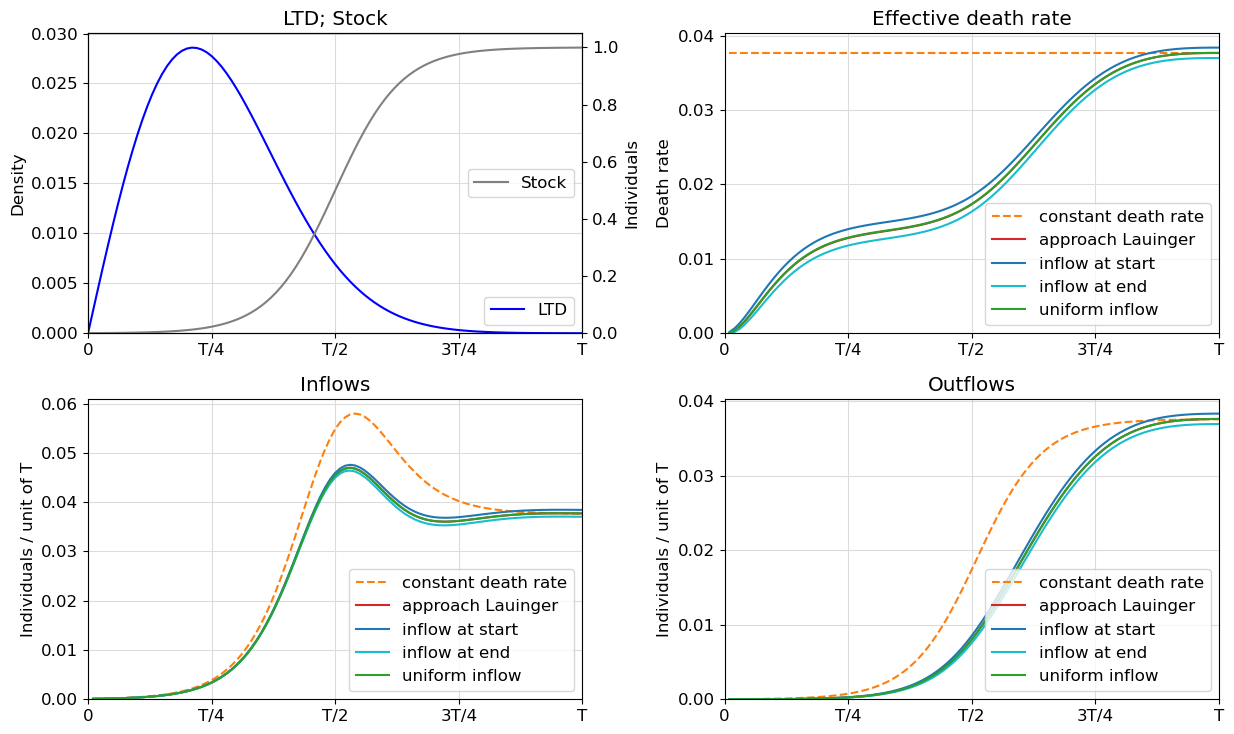

In [90]:
# -- plot the figure (part 1)
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})

# Stock
ax1=[]
#ax1 = plt.subplot(221, fc = 'w')
ax1.append(plt.subplot(221, fc = 'w'))
plt.plot(t,pdf(t), color='blue', label = 'LTD')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T])
# plt.xlabel('Time')
bottom, top = ax1[0].get_ylim()
ax1[0].set_ylim(0,top)
plt.ylabel('Density')
plt.title('LTD; Stock')
plt.grid(color='gainsboro')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')

#create plot on secondary y-axis of upper subplot
ax1.append(ax1[0].twinx())
plt.plot(t, S, color='grey', label = 'Stock')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Individuals')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'center right')

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')
plt.plot(t[1:], Dd, linestyle = '--', color = 'tab:orange', label = 'constant death rate')
plt.plot(t[1:], Do, linestyle = '-',  color = 'tab:red', label = 'approach Lauinger')
plt.plot(t[1:], Ds, linestyle = '-',  color = 'tab:blue', label = 'inflow at start')
plt.plot(t[1:], De, linestyle = '-',  color = 'tab:cyan', label = 'inflow at end')
plt.plot(t[1:], Du, linestyle = '-',  color = 'tab:green', label = 'uniform inflow')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Death rate')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# Inflows
ax3 = plt.subplot(223, facecolor = 'w')
plt.plot(t[1:], Id, '--', label = 'constant death rate', color = 'tab:orange')
plt.plot(t[1:], Io, label='approach Lauinger', color = 'tab:red')
plt.plot(t[1:], Is, label='inflow at start', color = 'tab:blue')
plt.plot(t[1:], Ie, label='inflow at end', color = 'tab:cyan')
plt.plot(t[1:], Iu, label='uniform inflow', color = 'tab:green')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Inflows')
plt.grid(color='gainsboro')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')
plt.plot(t[1:], Od, '--', label = 'constant death rate', color = 'tab:orange')
plt.plot(t[1:], Oo, label='approach Lauinger', color = 'tab:red')
plt.plot(t[1:], Os, label='inflow at start', color = 'tab:blue')
plt.plot(t[1:], Oe, label='inflow at end', color = 'tab:cyan')
plt.plot(t[1:], Ou, label='uniform inflow', color = 'tab:green')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Flows and stocks (stock-driven model).pdf',bbox_inches='tight')
#fig.savefig('Flows and stocks (stock-driven model).png',bbox_inches='tight', dpi=600)

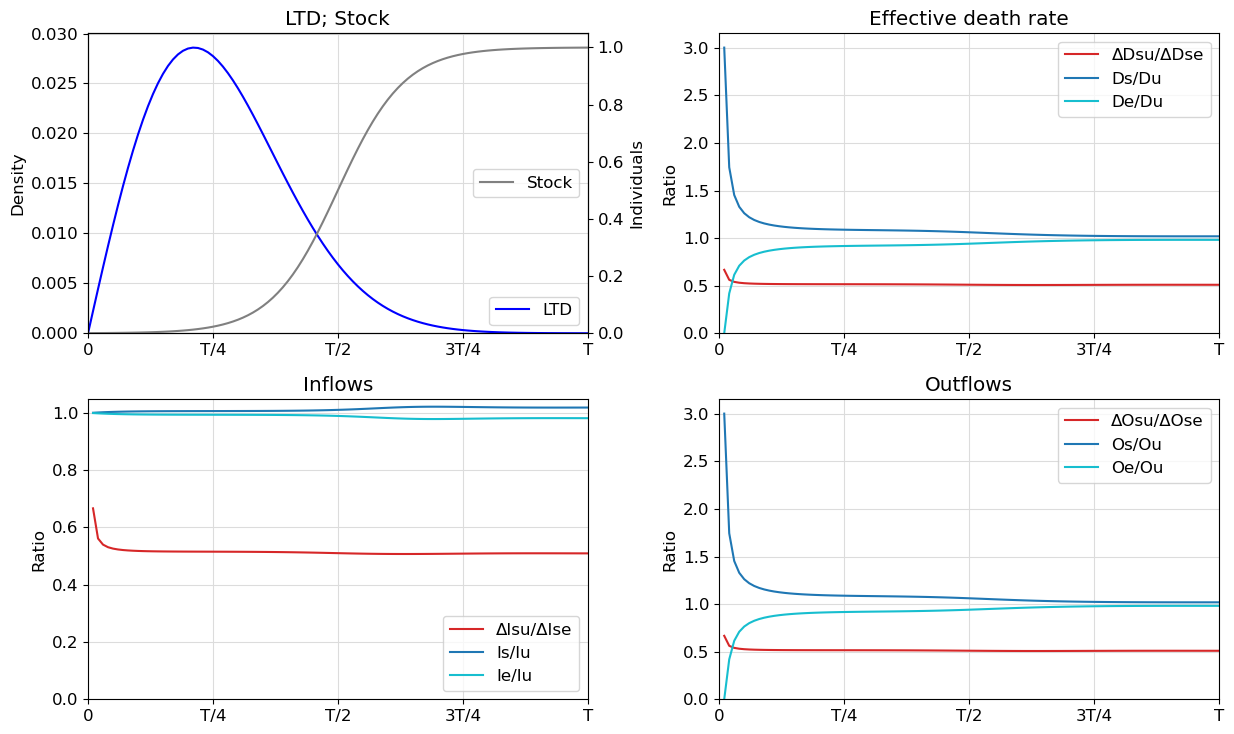

In [91]:
# -- plot the figure (part 2 - differences between different approaches)
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})

# Stock
ax1=[]
#ax1 = plt.subplot(221, fc = 'w')
ax1.append(plt.subplot(221, fc = 'w'))
plt.plot(t,pdf(t), color='blue', label = 'LTD')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
bottom, top = ax1[0].get_ylim()
ax1[0].set_ylim(0,top)
plt.ylabel('Density')
plt.title('LTD; Stock')
plt.grid(color='gainsboro')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')

#create plot on secondary y-axis of upper subplot
ax1.append(ax1[0].twinx())
plt.plot(t, S, color='grey', label = 'Stock')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
# plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'center right')

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')

dDsu = Ds-Du
dDse = Ds-De

condition = np.abs((Ds-De)/Du) > 1E-10
dDse = np.where(condition, dDse, np.nan)

plt.plot(t[1:], dDsu/dDse, linestyle = '-',  color = 'tab:red', label = 'ΔDsu/ΔDse')
plt.plot(t[1:], Ds/Du, linestyle = '-',  color = 'tab:blue', label = 'Ds/Du')
plt.plot(t[1:], De/Du, linestyle = '-',  color = 'tab:cyan', label = 'De/Du')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# Inflows
ax3 = plt.subplot(223, facecolor = 'w')

dIsu = Is-Iu
dIse = Is-Ie

condition = np.abs((Is-Ie)/Iu) > 1E-10
dIse = np.where(condition, dIse, np.nan)

plt.plot(t[1:], dIsu/dIse, linestyle = '-',  color = 'tab:red', label = 'ΔIsu/ΔIse')
plt.plot(t[1:], Is/Iu, linestyle = '-',  color = 'tab:blue', label = 'Is/Iu')
plt.plot(t[1:], Ie/Iu, linestyle = '-',  color = 'tab:cyan', label = 'Ie/Iu')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Inflows')
plt.grid(color='gainsboro')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')

dOsu = Os-Ou
dOse = Os-Oe

condition = np.abs((Os-Oe)/Ou) > 1E-10
dOse = np.where(condition, dOse, np.nan)

plt.plot(t[1:], dOsu/dOse, linestyle = '-',  color = 'tab:red', label = 'ΔOsu/ΔOse')
plt.plot(t[1:], Os/Ou, linestyle = '-',  color = 'tab:blue', label = 'Os/Ou')
plt.plot(t[1:], Oe/Ou, linestyle = '-',  color = 'tab:cyan', label = 'Oe/Ou')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Ratios (stock-driven model).pdf',bbox_inches='tight')
#fig.savefig('Ratios (stock-driven model).png',bbox_inches='tight', dpi=600)

## Lifetime (input driven model)

The figures created in this section compare the evolution of outflows and stocks under a time independent lifetime distribution for a model with constant/random/logistic input. 

In [95]:
# -- define the outflow and stock as a function of the input and the lifetime distribution

def O(I,L):
    return L.dot(I)

def dS(I,L):
    return(I-O(I,L))

def S(I,L):
    return np.append([0],np.cumsum(dS(I,L)))

def SD(I,D):
    return np.append([0],D.dot(I))

def OD(Sd,d):
    return Sd[:-1]*d*dt


In [57]:
# -- define input

inp = 1

if inp == 1: # continuous input
    I_cont = 10
    I_rate = np.ones(len(t))*I_cont   # pdf continous input function; unit mass per time
#    def I_rate(x):
#        return I_cont

elif inp == 2: # random input
    rd.seed(1)
    I_upper = 10
    I_lower = 5
    I_rate = np.ones(len(t))   # pdf continous input function; unit mass per time
    for i in range(N+1):
        I_rate[i]=I_rate[i]*rd.uniform(I_lower,I_upper)
#    def I_rate(x):
#        return I_cont
    
else: # logistic input growth
    I_max = 10
    T1 = 100
    s = 15/T1   # shape factor for the logistic stock growth (1/time)
    m = 0.5*T1  # mean value of the logistic function (time)
    I_rate = I_max/(1 + np.exp(-s*(t-m)))
#    def I_rate(x):
#        return I_max/(1 + np.exp(-s*(x-m)))

# approximated integration: mass input per period dt
I = (I_rate[:-1]+I_rate[1:])/2*dt

D = np.zeros((N,N))
for n in range(N-1):
    D = D + np.diag(np.ones(N - n)*(1-d*dt)**n, k = -n)

In [59]:
# -- Simplify used variable names

Sd = SD(I,D)
So = S(I, Lo)
Ss = S(I, Ls)
Se = S(I, Le)
Su = S(I, Lu)

Od = OD(Sd, d)/dt
Oo = O(I, Lo)/dt
Os = O(I, Ls)/dt
Oe = O(I, Le)/dt
Ou = O(I, Lu)/dt

Dd = Od[1:]/Sd[1:N]
Do = Oo[1:]/So[1:N]
Ds = Os[1:]/Ss[1:N]
De = Oe[1:]/Se[1:N]
Du = Ou[1:]/Su[1:N]


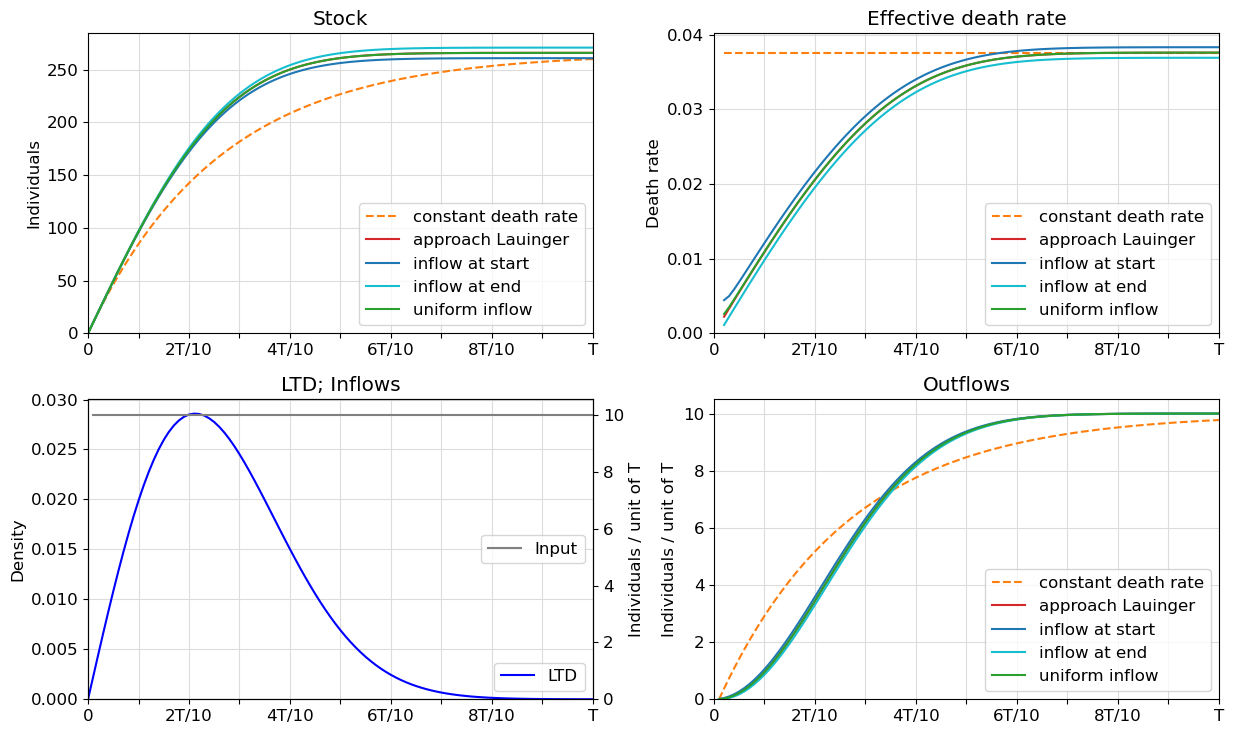

In [61]:
# -- plot the figure (part 1)
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})

# Stock
ax1 = plt.subplot(221, fc = 'w')
plt.plot(t, Sd, linestyle = '--', color = 'tab:orange', label = 'constant death rate')
plt.plot(t, So, color='tab:red', label = 'approach Lauinger')
plt.plot(t, Ss, color='tab:blue', label = 'inflow at start')
plt.plot(t, Se, color='tab:cyan', label = 'inflow at end')
plt.plot(t, Su, color='tab:green', label = 'uniform inflow')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals')
plt.title('Stock')
plt.grid(color='gainsboro')

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')
# ToDo: start computation first period after I was bigger than 0
plt.plot(t[2:], np.ones(N-1)*d, linestyle = '--', color = 'tab:orange', label = 'constant death rate')
# plt.plot(t[2:], Dd, linestyle = '--', color = 'tab:orange', label = 'constant death rate') ' check OK!
plt.plot(t[2:], Do, linestyle = '-',  color = 'tab:red', label = 'approach Lauinger')
plt.plot(t[2:], Ds, linestyle = '-',  color = 'tab:blue', label = 'inflow at start')
plt.plot(t[2:], De, linestyle = '-',  color = 'tab:cyan', label = 'inflow at end')
plt.plot(t[2:], Du, linestyle = '-',  color = 'tab:green', label = 'uniform inflow')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Death rate')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# LTD; Inflows
#ax3 = plt.subplot(223, facecolor = 'w')
ax3=[]
ax3.append(plt.subplot(223, fc = 'w'))

plt.plot(t,pdf(t), color='blue', label = 'LTD')
bottom, top = ax3[0].get_ylim()
ax3[0].set_ylim(0,top)
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.ylabel('Density')
plt.title('LTD; Inflows')
plt.grid(color='gainsboro')

#create plot on secondary y-axis of upper subplot
ax3.append(ax3[0].twinx())

plt.plot(t[1:], I/dt, label = 'Input', color = 'grey')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'center right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Individuals / unit of T')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')
plt.plot(t[1:], Od, linestyle = '--', color = 'tab:orange', label = 'constant death rate')
plt.plot(t[1:], Oo, label='approach Lauinger', color = 'tab:red')
plt.plot(t[1:], Os, label='inflow at start', color = 'tab:blue')
plt.plot(t[1:], Oe, label='inflow at end', color = 'tab:cyan')
plt.plot(t[1:], Ou, label='uniform inflow', color = 'tab:green')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Flows and stocks (inflow-driven model).pdf',bbox_inches='tight')
#fig.savefig('Flows and stocks (inflow-driven model).png',bbox_inches='tight', dpi=600)

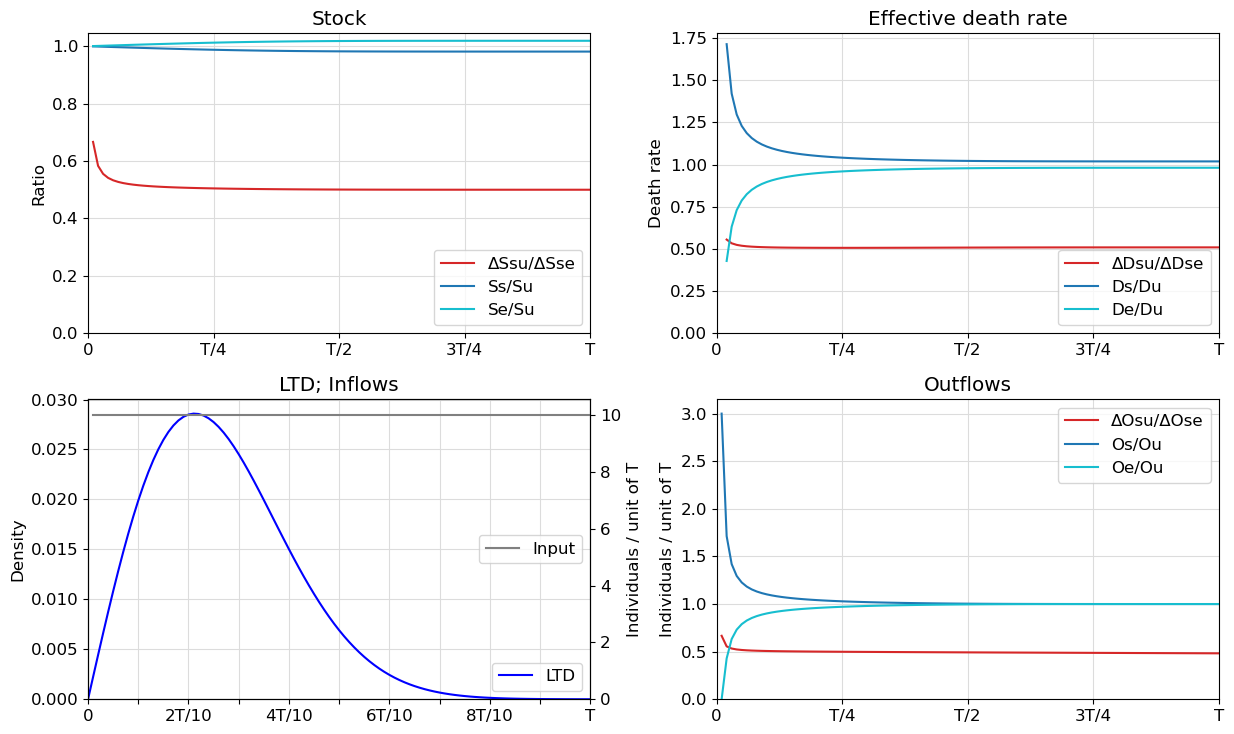

In [62]:
# -- plot the figure (part 2 - differences between different approaches)
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 12})

# Stock
ax1 = plt.subplot(221, fc = 'w')

dSsu = (Ss-Su)
dSse = (Ss-Se)

condition = np.abs(dSse[1:]/Su[1:]) > 1E-10
dSse = np.where(condition, dSse[1:], np.nan)

plt.plot(t[1:], dSsu[1:]/dSse, linestyle = '-',  color = 'tab:red', label = 'ΔSsu/ΔSse')
plt.plot(t[1:], Ss[1:]/Su[1:], linestyle = '-',  color = 'tab:blue', label = 'Ss/Su')
plt.plot(t[1:], Se[1:]/Su[1:], linestyle = '-',  color = 'tab:cyan', label = 'Se/Su')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T])
# plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Stock')
plt.grid(color='gainsboro')

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')

dDsu = Ds-Du
dDse = Ds-De

condition = np.abs((Ds-De)/Du) > 1E-10
dDse = np.where(condition, dDse, np.nan)

plt.plot(t[2:], dDsu/dDse, linestyle = '-',  color = 'tab:red', label = 'ΔDsu/ΔDse')
plt.plot(t[2:], Ds/Du, linestyle = '-',  color = 'tab:blue', label = 'Ds/Du')
plt.plot(t[2:], De/Du, linestyle = '-',  color = 'tab:cyan', label = 'De/Du')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Death rate')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# Inflows
#ax3 = plt.subplot(223, facecolor = 'w')
ax3=[]
ax3.append(plt.subplot(223, fc = 'w'))

plt.plot(t,pdf(t), color='blue', label = 'LTD')
bottom, top = ax3[0].get_ylim()
ax3[0].set_ylim(0,top)
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'lower right')
plt.ylabel('Density')
plt.title('LTD; Inflows')
plt.grid(color='gainsboro')

#create plot on secondary y-axis of upper subplot
ax3.append(ax3[0].twinx())

plt.plot(t[1:], I/dt, label = 'Input', color = 'grey')
plt.legend(facecolor = 'w', fontsize = '12', loc = 'center right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Individuals / unit of T')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')

dOsu = Os-Ou
dOse = Os-Oe

condition = np.abs((Os-Oe)/Ou) > 1E-10
dOse = np.where(condition, dOse, np.nan)

plt.plot(t[1:], dOsu/dOse, linestyle = '-',  color = 'tab:red', label = 'ΔOsu/ΔOse')
plt.plot(t[1:], Os/Ou, linestyle = '-',  color = 'tab:blue', label = 'Os/Ou')
plt.plot(t[1:], Oe/Ou, linestyle = '-',  color = 'tab:cyan', label = 'Oe/Ou')

plt.legend(facecolor = 'w', fontsize = '12', loc = 'upper right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
#plt.ylabel('Individuals / unit of T, ↕')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Ratios (inflow-driven model).pdf',bbox_inches='tight')
#fig.savefig('Ratios (inflow-driven model).png',bbox_inches='tight', dpi=600)